In [2]:
import os 
import pandas as pd 
import numpy as np 
from glob import glob
# from scipy import signal, fft
# from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

import scipy.signal
from scipy.signal.windows import hann

# import torch
# import torchaudio
# from torch.utils.data import Dataset

import tensorflow as tf 


import matplotlib.pyplot as plt
import librosa.display
from PIL import Image
import numpy as np

In [3]:
all_files = pd.read_csv('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/files.csv')
all_files.head()

,filename,train/test,sounds_amount
0,423_c.wav,train,24
1,113_c.wav,train,6
2,377_c.wav,train,5
3,25_g.wav,train,4
4,112_c.wav,train,9


In [4]:
len(all_files[(all_files['sounds_amount'] > 0) & (all_files['train/test']  == 'train')]), len(all_files[(all_files['sounds_amount'] == 0) & (all_files['train/test']  == 'train')])

(1023, 262)

In [5]:
len(all_files[(all_files['sounds_amount'] > 0) & (all_files['train/test']  == 'test')]), len(all_files[(all_files['sounds_amount'] == 0) & (all_files['train/test']  == 'test')])

(260, 61)

In [6]:
wav_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*_c.wav')
csv_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*_c.csv')
len(wav_files), len(csv_files)

(427, 427)

In [7]:
wav_train, wav_test = [], [] 
csv_train, csv_test = [], [] 

# for i in range(len(wav_files)):
for key, val in all_files.iterrows():
    if 'train' in val['train/test']:
        wav_train.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename']))
        csv_train.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename'].replace('wav', 'csv')))
    else:
        wav_test.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename']))
        csv_test.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename'].replace('wav', 'csv')))

In [8]:
len(wav_train), len(wav_test), len(csv_train), len(csv_test)

(1285, 321, 1285, 321)

In [9]:
total_category = {} 
for csv in csv_train:
    df = pd.read_csv(csv)
    
    try:
        unique_elements, counts = np.unique(df['category'].astype(str), return_counts=True)
        # element_counts_dict = dict(zip(unique_elements, counts))
        
        if len(unique_elements) < 1:
            continue
        
        for e, c in zip(unique_elements, counts):
            if e in total_category:
                total_category[e] += c
            else:
                total_category[e] = c
    except Exception as e:
        print(e)
            
    # break

total_category
        

{'s': 2819, 'm': 16, 'nan': 2152, 'b': 90, 'bc': 94, 'o': 1, 'a': 32, 'd': 2}

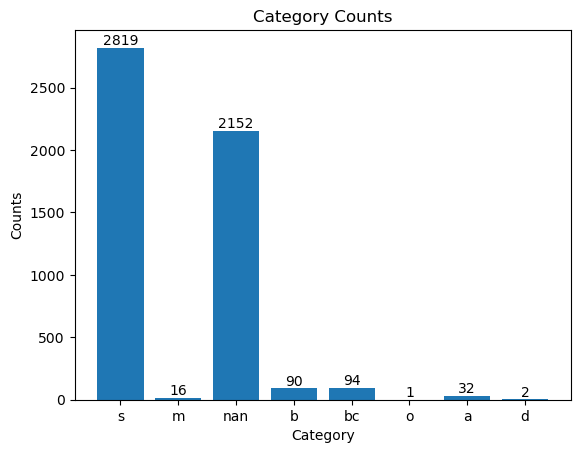

In [10]:
categories = list(total_category.keys())
counts = list(total_category.values())

# 막대 그래프 생성
plt.bar(categories, counts)

for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')


plt.xlabel('Category')  # X축 레이블
plt.ylabel('Counts')    # Y축 레이블
plt.title('Category Counts')  # 그래프 제목
plt.show()

In [11]:
df = pd.read_csv(csv_train[0])
df.head()

,start,end,fmin,fmax,category
0,0.014694,0.046621,165.242172,1903.133911,s
1,0.183039,0.213515,216.524216,1954.415894,s
2,0.339773,0.374603,216.524216,598.290649,s
3,0.583583,0.606803,119.658119,592.592590,s
4,0.879637,0.917370,153.846161,723.646729,s


In [12]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply the designed filter to a data sequence
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [18]:
x_train, y_train = [], [] 
x_test, y_test = [], [] 

n_fft = 441
hop_length = 110 

max_second = 0 
max_freq = 0
for wav in wav_train:

    y, sr = librosa.load(wav, sr=44100)
    
    cutoff = 1500  # Set your desired cutoff frequency here
    y_filtered = butter_lowpass_filter(y, cutoff, sr)
    # for _ in range(49):
    #     print('----->', )
    #     y_filtered = np.concatenate((y_filtered, y_filtered), axis=0)
        
    D = librosa.stft(y_filtered, n_fft=n_fft, hop_length=hop_length, window='hann', center=False)
    D_amp = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    time_res = len(y) / sr / D_amp.shape[0]
    freq_res = sr / 2 / D_amp.shape[1]
    
    csv_df = pd.read_csv(wav.replace('wav', 'csv')) 
    
    for idx, row in csv_df.iterrows():
        
        if 'nan' in str(row['fmax']):
            continue
        
        fmin = int(row['fmin'] / freq_res)
        fmax = int(row['fmax'] / freq_res)
        start = int(row['start'] / time_res)
        end = int(row['end'] / time_res)
        category = row['category']
        
        if (end - start) > 0:
        
            if (end - start) > max_second:
                max_second = end - start
                
            if (fmax - fmin) > max_freq:
                max_freq = fmax - fmin
                
            # slice = D_amp[start:end, fmin:fmax]
            slice = D_amp[start:end, :103]
            x_train.append(slice)
            
            if 'nan' in str(category):
                y_train.append(0)
            else:
                y_train.append(1)
        else:            
            print('------', end - start)

    
    

------ 0


In [19]:
# np.array(x_train).shape
len(x_train), x_train[0].shape, x_train[1].shape, max_second, max_freq

(4337, (4, 103), (3, 103), 229, 103)

In [20]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1283, 3054]))

In [21]:
# def repeat_waveform(waveform, max_second, max_freq):

x_train_new = np.zeros((len(x_train), max_second, max_freq))
for idx, x in enumerate(x_train):
    # print(x.shape)
    num_frames = x.shape[0]
    # print(num_frames)
    # num_frames = x.shape[1] - x.shape[0]
    if num_frames > 0:
        target_num_frames = int(max_second)
        # target_num_frames = int(max_second)

        if num_frames < target_num_frames:
            # Repeat the waveform to reach the target duration
            repetitions = (target_num_frames // num_frames) + 1
            waveform = np.repeat(x, repetitions, axis=0)
            num_frames = waveform.shape[0]

        # Trim or repeat to match the exact target duration
        if num_frames > target_num_frames:
            waveform = waveform[:target_num_frames, :]
            
        # print(waveform.shape)
        x_train_new[idx]  = waveform

# x_train_new.append(waveform)


In [109]:
test = np.random.rand(13, 28)
# test.shape
np.repeat(test, 2, axis=0).shape

(26, 28)

In [22]:
x_train_new[0].shape, x_train_new[1].shape, x_train_new[2].shape

((229, 103), (229, 103), (229, 103))

In [26]:
y_train = np.array(y_train)
np.where(y_train == 0)

(array([  35,   36,   37, ..., 4333, 4334, 4335]),)

In [25]:
y_train[0], y_train[1]

(1, 1)

In [29]:
x_train_new[34]

array([[-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       ...,
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.]])

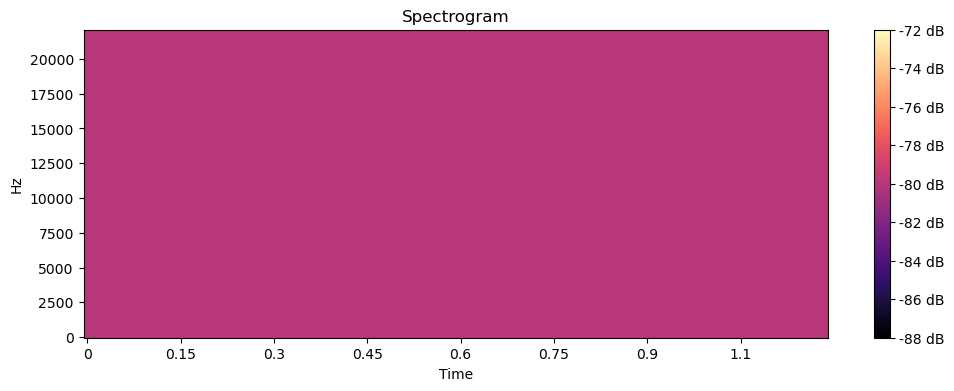

In [27]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_train_new[34], sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

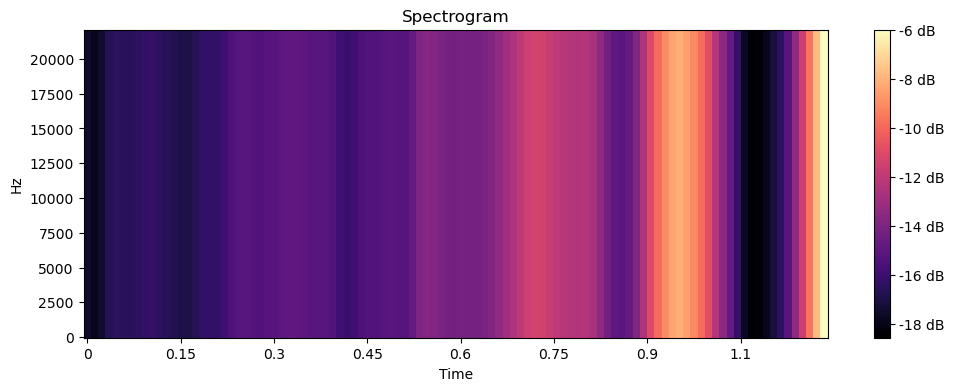

In [28]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_train_new[35], sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [122]:
x_train_new[1], x_train[1]

(array([[-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        ...,
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.]]),
 array([[-80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -80., -80., -80., -80., -80.],
        [-80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -80., -80., -80., -80., -80.],
        [-80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -80., -80., -80., -80., -80.],
        [-80., -80., -80., -80., -80., -80., -80., -80., -80., -80., -80.,
         -80., -

0
0.2282089999999925 0.265940999999998 0.03773200000000548
25 29 4
1
0.292063000000013 0.3414060000000063 0.04934299999999331
32 37 5
2
0.5184580000000096 0.5532880000000091 0.03482999999999947
57 61 4
3
0.6461679999999888 1.2818139999999971 0.6356460000000084
71 141 70
4
1.6765530000000126 2.4282990000000098 0.7517459999999971
185 268 83


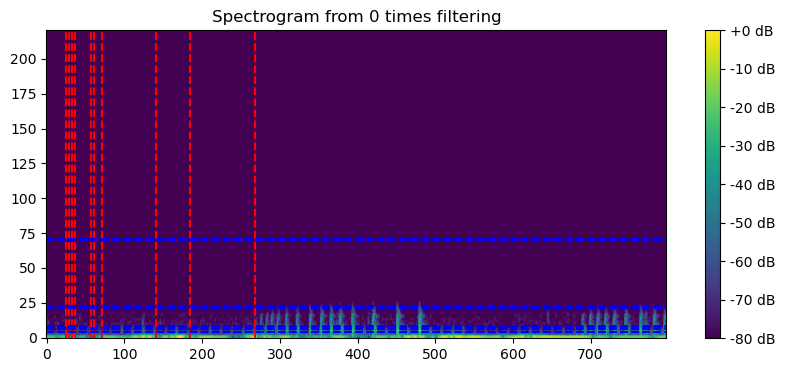

In [33]:
# y_filtered = butter_lowpass_filter(y_filtered, cutoff, sr)
# D = librosa.stft(y_filtered, n_fft=n_fft, hop_length=hop_length, window='hann', center=False)
# D_amp = librosa.amplitude_to_db(np.abs(D), ref=np.max)
num = 20 

y, sr = librosa.load(wav_train[num], sr=44100)
csv_df = pd.read_csv(wav_train[num].replace('wav', 'csv'))
y_filtered = y

for ii in range(100):
    # Define the time and frequency resolution
    y_filtered = butter_lowpass_filter(y_filtered, cutoff, sr)
    D = librosa.stft(y_filtered, n_fft=n_fft, hop_length=hop_length, window='hann', center=False)
    D_amp = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    if ii % 50 != 0:
         continue
    
    
    time_res = len(y) / sr / D_amp.shape[0]
    freq_res = sr / 2 / D_amp.shape[1]

    plt.figure(figsize=(10, 4))
    plt.imshow(D_amp, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(format='%+2.0f dB')

    # Iterate over the rows in the DataFrame
    for index, row in csv_df.iterrows():
        print(index)
        start_bin = int(row['start'] / time_res)
        end_bin = int(row['end'] / time_res)
        fmin_bin = int(row['fmin'] / freq_res)
        fmax_bin = int(row['fmax'] / freq_res)

        # Extract the slice from the spectrogram
        # slice = D_amp[fmin_bin:fmax_bin, start_bin:end_bin]
        # slice = D_amp[start_bin:end_bin, fmin_bin:fmax_bin]
        
        # plt.figure(figsize=(10, 4))
        # plt.imshow(slice, aspect='auto', cmap='viridis', origin='lower')
        # plt.title('Spectrogram Slice')
        # plt.colorbar(format='%+2.0f dB')
        # plt.show()
        # print(row['start'], row['end'], row['end'] - row['start'])
        # print(start_bin, end_bin, end_bin - start_bin)
        # print(slice.shape)
        
        # Draw vertical lines at the start and end times of each slice
        plt.axvline(start_bin, color='r', linestyle='--')
        plt.axvline(end_bin, color='r', linestyle='--')
        
        plt.axhline(fmin_bin, color='b', linestyle='--')
        plt.axhline(fmax_bin, color='b', linestyle='--')
        
    break

plt.title(f'Spectrogram from {str(ii)} times filtering')
plt.show()

In [100]:
len(x_train_new), x_train_new.shape, type(x_train_new), type(y_train)

(4337, (4337, 827, 28), numpy.ndarray, list)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

# Assuming X is your 3D array of spectrogram slices and y are the labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
X_train = np.array(x_train_new) / 255.0
y_train = np.array(y_train)
# X_test = X_test / 255.0

# Reshape the data to include the channel dimension
# X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
# X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
# print('\nTest accuracy:', test_acc)

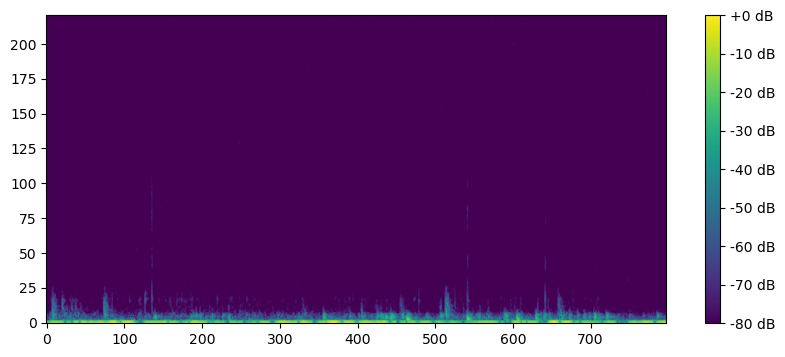

In [73]:
D1 = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann', center=False)
D_amp1 = librosa.amplitude_to_db(np.abs(D1), ref=np.max)

plt.figure(figsize=(10, 4))
plt.imshow(D_amp1, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(format='%+2.0f dB')

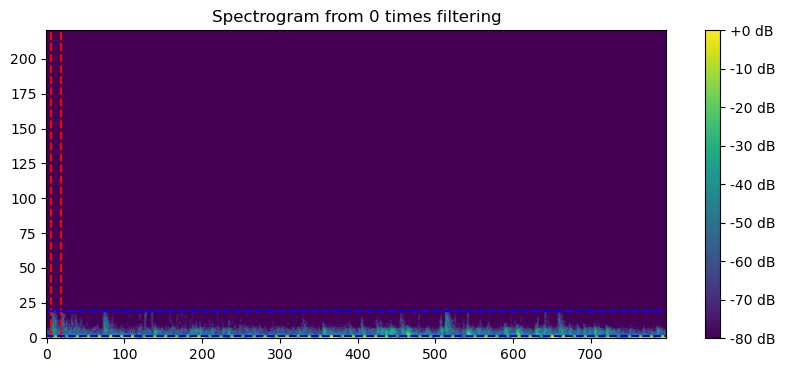

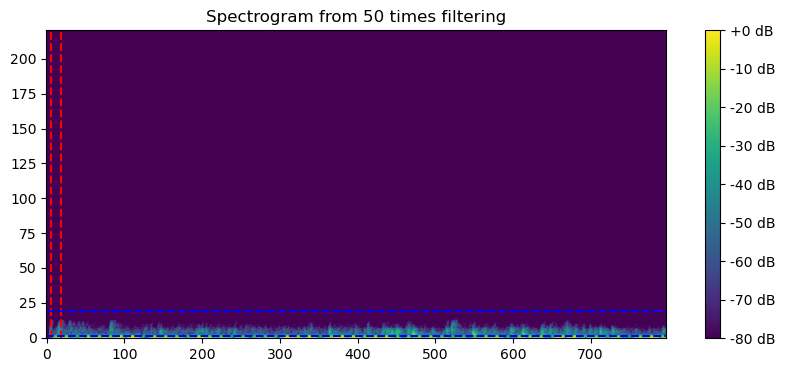

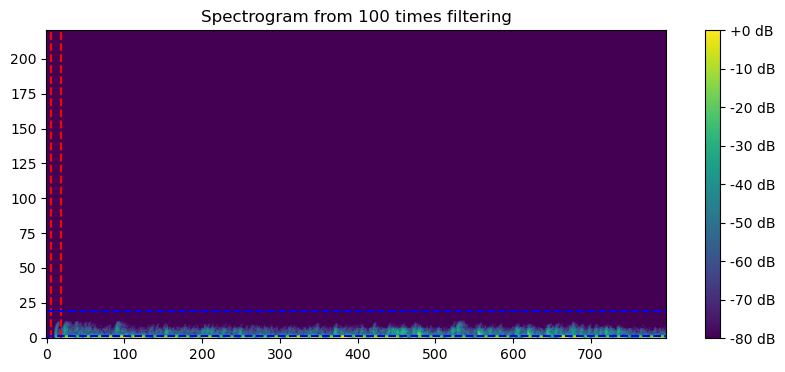

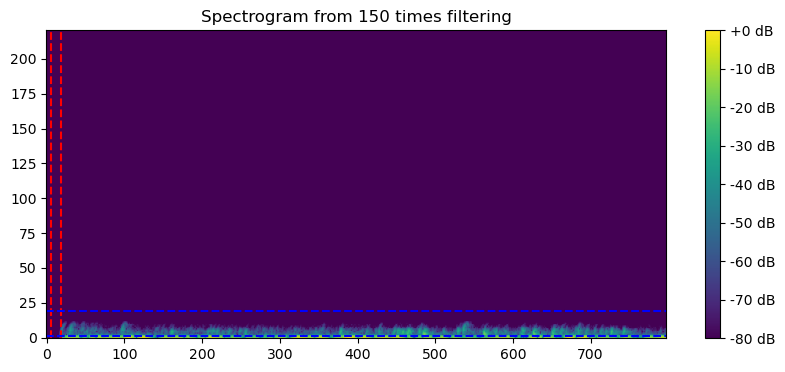

In [91]:
# y_filtered = butter_lowpass_filter(y_filtered, cutoff, sr)
# D = librosa.stft(y_filtered, n_fft=n_fft, hop_length=hop_length, window='hann', center=False)
# D_amp = librosa.amplitude_to_db(np.abs(D), ref=np.max)

y_filtered = y

for ii in range(100):
    # Define the time and frequency resolution
    y_filtered = butter_lowpass_filter(y_filtered, cutoff, sr)
    D = librosa.stft(y_filtered, n_fft=n_fft, hop_length=hop_length, window='hann', center=False)
    D_amp = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    if ii % 50 != 0:
         continue
    
    
    time_res = len(y) / sr / D_amp.shape[1]
    freq_res = sr / 2 / D_amp.shape[0]

    plt.figure(figsize=(10, 4))
    plt.imshow(D_amp, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(format='%+2.0f dB')

    # Iterate over the rows in the DataFrame
    for index, row in csv_df.iterrows():
        start_bin = int(row['start'] / time_res)
        end_bin = int(row['end'] / time_res)
        fmin_bin = int(row['fmin'] / freq_res)
        fmax_bin = int(row['fmax'] / freq_res)

        # Extract the slice from the spectrogram
        # slice = D_amp[fmin_bin:fmax_bin, start_bin:end_bin]
        slice = D_amp[start_bin:end_bin, fmin_bin:fmax_bin]
        
        # plt.figure(figsize=(10, 4))
        # plt.imshow(slice, aspect='auto', cmap='viridis', origin='lower')
        # plt.title('Spectrogram Slice')
        # plt.colorbar(format='%+2.0f dB')
        # plt.show()
        
        # print(start_bin, end_bin)
        # print(slice.shape)
        
        # Draw vertical lines at the start and end times of each slice
        plt.axvline(start_bin, color='r', linestyle='--')
        plt.axvline(end_bin, color='r', linestyle='--')
        
        plt.axhline(fmin_bin, color='b', linestyle='--')
        plt.axhline(fmax_bin, color='b', linestyle='--')
        
        break

    plt.title(f'Spectrogram from {str(ii)} times filtering')
    plt.show()

In [92]:
D_amp.shape, slice.shape

((221, 798), (13, 18))

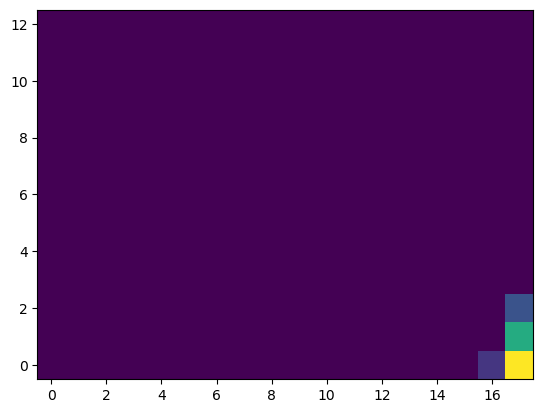

In [93]:
plt.imshow(slice, aspect='auto', cmap='viridis', origin='lower')

In [71]:
# --- WAV file

In [91]:
def resampling(sig, sample_rate, resample_rate):
    if sample_rate != resample_rate:
        sig = librosa.resample(sig, orig_sr=sample_rate, target_sr=resample_rate)
        sample_rate = resample_rate
        return sig            

    return sig

def normalization(sig):
    return (sig-sig.mean())/sig.std()

def low_pass_filter(wf, sample_rate, high_cut, filter_repetition_count=1):

    waveform = torch.from_numpy(wf)
    for i in range(filter_repetition_count):
        waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=high_cut, Q=0.707)
    waveform = waveform.numpy()
    return waveform
    

def band_pass_filter(waveform, sample_rate):
    waveform = torch.from_numpy(waveform)
    band_pass_waveform = torchaudio.functional.bandpass_biquad(waveform, sample_rate, central_freq=500, Q=2)
    return waveform.numpy()

In [92]:
class MelSpecto:
    def __init__(self, s_r, o_f, f_n, n_mels=80):
        self.sample_rate = s_r
        self.output_folder = o_f
        self.file_name = f_n
        self.n_mels = n_mels

    def image_save(self, sig, figsize):
        """
        1. n_fft : length of the windowed signal after padding with zeros.

              한 번 fft를 해 줄 만큼의 sequence 길이

        2. hop_length : window 간의 거리 라이브러리 default = 512

        3. win_length : window 길이

        :param sig: wave_form
        :param m_s: max_second
        :return:
        """
        plt.figure(figsize=figsize)
        # n_fft = 512
        # hop_length = 200
        # frame_length = 0.064
        # frame_stride = 0.025
        # n_fft = int(round(self.sample_rate * frame_length))
        # hop_length = int(round(self.sample_rate * frame_stride))

        '''
        win length: 
         - 음성을 작은 조각으로 자를 때 작은 조각의 크기를 의미
         - 자연어 처리 분야에서 25ms의 크기를 기본으로 함 
         - sr / 40
         
        n_fft
         - win_length의 크기로 잘린 음성의 작은 조각은 0으로 패딩되어서 n_fft로 크기가 맞춰짐
         - 패딩된 조각에 푸리에현봔이 적용되기 때문에 n_fft는 win_length보다 크거나 같아야하고 일반적으로 속도를 위해 2의 제곱근으로 설정함
                     
        hop_length
         - 음성을 작은 조각으로 자를 때 자르는 간격을 의미
         - 이 길이 만큼 옆으로 밀면서 작은 조각을 얻음
         - 일반적으로 10ms의 크기를 기본으로 함
         
        n_mels 
         - 적용할 mel filter의 개수를 의미
         
         
         
        우리가 보유한 데이터가 7초이고, window_length를 0.025초, frame_stride를 0.010초(10ms)단위로 뽑는다고 가정하면, 
        1칸은 0.015초(15ms)가 겹치도록 하여 총 700칸을 얻을 수 있다.
        '''
        frame_length = 0.025
        frame_stride = 0.01
        win_length = int(round(self.sample_rate * frame_length))
        n_fft = win_length
        hop_length = int(round(self.sample_rate * frame_stride))
        n_mels_dict = {4000: 64, 8000: 64, 12000: 128, 16000: 128, 20000: 128, 24000: 512}
        n_mels = n_mels_dict[self.sample_rate]
        # fmax = ?

        # display spectrogram
        mel = librosa.feature.melspectrogram(y=np.array(sig), sr=self.sample_rate, n_fft=n_fft, hop_length=hop_length,
                                             win_length=win_length, n_mels=n_mels)
        # , y_axis='mel', x_axis='time'
        librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=self.sample_rate)

        # display spectrogram
        # mel = librosa.feature.melspectrogram(y=np.array(sig), sr=self.sample_rate)
        # # , y_axis='mel', x_axis='time'
        # librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=self.sample_rate)

        plt.savefig(f'{self.output_folder}/{self.file_name}.png', bbox_inches="tight", pad_inches=0)
        plt.plot()
        plt.close()

        # 삭제 말구 잘리는 annotation 부분 지우기
        # img = F.to_pil_image(image)
        # image = Image.open(f'{self.output_folder}/{self.file_name}.png')
        # w, h = image.size
        # # crop을 통해 이미지 자르기       (left,up, rigth, down)
        # croppedImage = image.crop((0, 0, w - 10, h))
        # croppedImage.save(f'{self.output_folder}/{self.file_name}.png')

In [93]:
waveform, sample_rate = torchaudio.load(wav_files[0])
sig, sr = librosa.load(wav_files[0], sr=sample_rate)

In [94]:
len(sig) / sr # 2 seconds

2.0

In [95]:
waveform.shape, sample_rate, sig.shape, sr

(torch.Size([1, 88200]), 44100, (88200,), 44100)

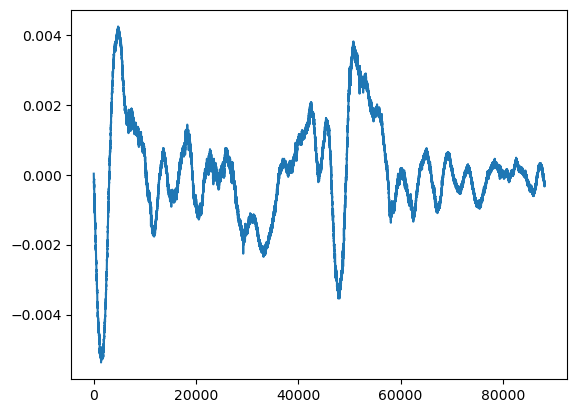

In [96]:
plt.plot(sig)

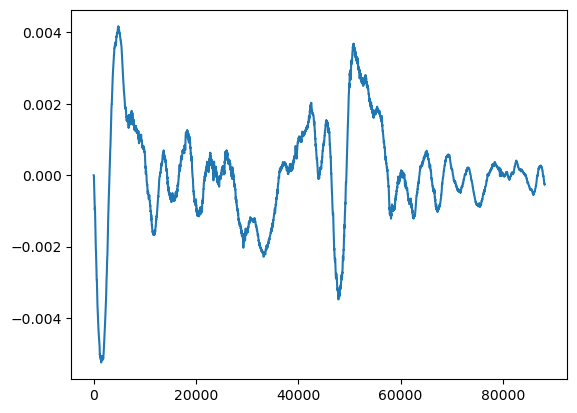

In [97]:
low_pass_filterd_resampled_sig = low_pass_filter(sig, sample_rate=sample_rate, high_cut=500)
# low_pass_filterd_resampled_sig.shape
plt.plot(low_pass_filterd_resampled_sig)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     3 non-null      float64
 1   end       3 non-null      float64
 2   fmin      3 non-null      float64
 3   fmax      3 non-null      float64
 4   category  3 non-null      object 
dtypes: float64(4), object(1)
memory usage: 252.0+ bytes


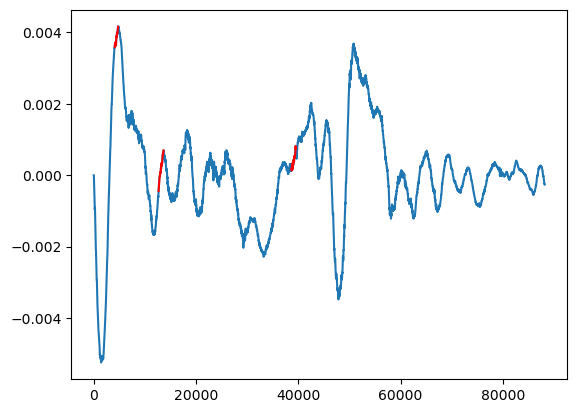

In [99]:
low_pass_filterd_resampled_sig = low_pass_filter(sig, sample_rate=sample_rate, high_cut=500)

plt.plot(low_pass_filterd_resampled_sig)

for idx, val in df.iterrows():
    
    start_time = int(val['start'] * sample_rate)
    end_time = int(val['end'] * sample_rate)
    plt.plot(range(start_time, end_time), low_pass_filterd_resampled_sig[start_time:end_time], color='red')

plt.show()

In [100]:
from IPython.display import Audio
Audio(data=sig, rate=sample_rate)


In [102]:
Audio(data=low_pass_filterd_resampled_sig, rate=sr)


In [105]:
# melspc = MelSpecto()
sig1, sr1 = librosa.load('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/235_a.wav')
low_pass_filterd_resampled_sig1 = low_pass_filter(sig1, sample_rate=sample_rate, high_cut=500)

Audio(data=low_pass_filterd_resampled_sig1, rate=sr1)


In [ ]:
sig2, sr2 = librosa.load('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/235_c.wav')
Audio(data=sig2, rate=sr2)